# Data Analysis 3 - Assignment 1
## Predicting airbnb house prices in Spain
Author: Borbala Kovacs

Date: 2/2/2026


### Data preparation and cleaning code for the training and the two testing datasets 

In [1]:
# Run the data cleaning notebook
%run house_price_prediction_data_prep.ipynb


CLEANING: madrid_25q1

Loaded: 25288 rows, 79 columns
After price filter: 19179 rows
After excluding hotels/hostels: 18688 rows

Final shape: (18169, 71)
Saved to: C:\Users\borik\Desktop\Data-Analysis-3\assignment1\data\clean/airbnb_madrid_25q1_clean.csv
Price: mean=121, median=98

CLEANING: madrid_25q2

Loaded: 26004 rows, 79 columns
After price filter: 19969 rows
After excluding hotels/hostels: 19481 rows

Final shape: (19035, 71)
Saved to: C:\Users\borik\Desktop\Data-Analysis-3\assignment1\data\clean/airbnb_madrid_25q2_clean.csv
Price: mean=124, median=101

CLEANING: valencia_25q1

Loaded: 8847 rows, 79 columns
After price filter: 8081 rows
After excluding hotels/hostels: 7945 rows

Final shape: (7606, 71)
Saved to: C:\Users\borik\Desktop\Data-Analysis-3\assignment1\data\clean/airbnb_valencia_25q1_clean.csv
Price: mean=131, median=114

ALL DATASETS CLEANED SUCCESSFULLY

Dataset Comparison:
--------------------------------------------------
madrid_25q1: 18,169 obs, 71 vars, mean pri

In [2]:
import os
import sys
import time
import warnings

import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

### Paths and setup

In [3]:
current_path = os.getcwd()
assignment_dir = os.path.dirname(current_path) if "code" in current_path else current_path

data_out = os.path.join(assignment_dir, "data", "clean/")
output = os.path.join(assignment_dir, "output/")

import py_helper_functions as da

sns.set_theme(style="whitegrid")

#### Load clean data

In [4]:
data = pd.read_csv(data_out + "airbnb_madrid_25q1_clean.csv")
print(f"Data shape: {data.shape}")

Data shape: (18169, 71)


## PART 1: OLS Models

----
#### Define variable groups

In [5]:
# Basic property characteristics - core drivers of price
basic_lev = (
    "n_accommodates",      # Capacity is primary price driver
    "n_beds",              # Number of beds
    "f_property_type",     # Apartment vs House
    "f_room_type",         # Entire place vs Private vs Shared
    "n_days_since",        # Time on platform (experience proxy)
    "flag_days_since",     # Flag for imputed values
)

# Additional property features
basic_add = (
    "f_bathroom",          # Bathroom categories
    "n_bedrooms",          # Number of bedrooms
)

# Review information - quality signals
reviews = (
    "f_number_of_reviews",       # Review count categories
    "n_review_scores_rating",    # Rating score
    "flag_review_scores_rating", # Flag for imputed ratings
)

# Polynomial terms - capture non-linear relationships
# Price increases with accommodates but at decreasing rate
poly_lev = (
    "n_accommodates2",     # Squared term for accommodates
    "ln_accommodates",     # Log transformation
)

# Host characteristics
host_vars = (
    "d_host_is_superhost",       # Superhost status (quality signal)
    "d_instant_bookable",        # Convenience feature
)

# Amenities - extracted from listing
amenities = tuple([c for c in data.columns if c.startswith('d_') and 'host' not in c and 'instant' not in c])
print(f"Number of amenity variables: {len(amenities)}")

Number of amenity variables: 31


### INTERACTION ANALYSIS
#### Visualizing potential interactions before including them


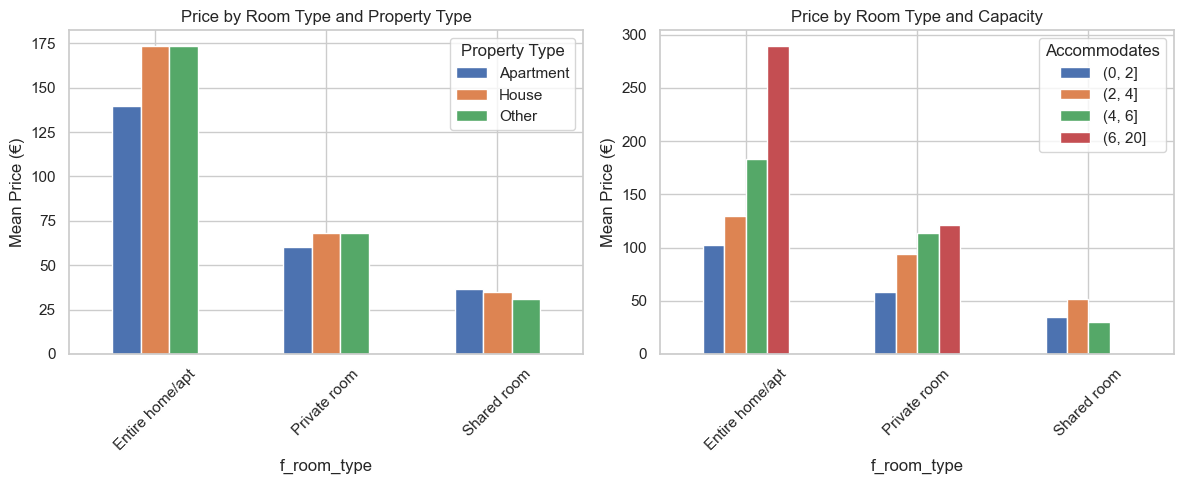

In [6]:
# Price by room type and property type - expect interaction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Interaction 1: Room type × Property type
data.groupby(['f_room_type', 'f_property_type'])['price'].mean().unstack().plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Price by Room Type and Property Type')
axes[0].set_ylabel('Mean Price (€)')
axes[0].legend(title='Property Type')

# Interaction 2: Room type × Accommodates
data.groupby(['f_room_type', pd.cut(data['n_accommodates'], bins=[0,2,4,6,20])])['price'].mean().unstack().plot(
    kind='bar', ax=axes[1], rot=45
)
axes[1].set_title('Price by Room Type and Capacity')
axes[1].set_ylabel('Mean Price (€)')
axes[1].legend(title='Accommodates')

plt.tight_layout()
plt.savefig(output + 'interactions_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpretation:
# - Entire homes have higher prices than private rooms across all property types
# - The price gap between entire unit and private room is larger for houses than for apartments
# - This suggests an interaction between room_type and property_type

# - Larger room capacity matters more for entire home/apartment than for a single room
# - This suggests an interaction between room_type and n_accomodates

### DEFINE INTERACTIONS
#### Based on domain knowledge and visual inspection

In [7]:
# X1: Core interactions - room type effect varies by property type and capacity
X1 = (
    "f_room_type*f_property_type",      # Premium for entire house vs entire apt differs
    "n_accommodates*f_room_type",        # Capacity effect differs by room type
)

# X2: Amenity interactions - some amenities matter more for certain property types
X2 = (
    "d_airconditioning*f_property_type",  # AC may matter more for apartments
    "d_wifi*f_room_type",                  # WiFi expected everywhere, but matters for private rooms
)

### BUILD MODEL SPECIFICATIONS
#### Progressive complexity: M1 -> M7

In [8]:
modellev1 = "~ n_accommodates"
modellev2 = "~ " + " + ".join(basic_lev)
modellev3 = "~ " + " + ".join(basic_lev + basic_add)
modellev4 = "~ " + " + ".join(basic_lev + basic_add + reviews)
modellev5 = "~ " + " + ".join(basic_lev + basic_add + reviews + poly_lev)
modellev6 = "~ " + " + ".join(basic_lev + basic_add + reviews + poly_lev + host_vars + X1)
modellev7 = "~ " + " + ".join(basic_lev + basic_add + reviews + poly_lev + host_vars + X1 + amenities)

model_equations = [modellev1, modellev2, modellev3, modellev4, modellev5, modellev6, modellev7]
model_names = ['M1: Accommodates only', 'M2: Basic', 'M3: +Property features', 
               'M4: +Reviews', 'M5: +Polynomials', 'M6: +Host & Interactions', 'M7: +Amenities']

### TRAIN/HOLDOUT SPLIT
#### 80% training, 20% holdout for final evaluation

In [9]:
np.random.seed(42)
data_work, data_holdout = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training set: {data_work.shape[0]} rows")
print(f"Holdout set: {data_holdout.shape[0]} rows")

Training set: 14535 rows
Holdout set: 3634 rows


### OLS MODELS WITH CROSS-VALIDATION
#### 5-fold CV to estimate out-of-sample RMSE

In [10]:
n_folds = 5

print("\n" + "="*60)
print("RUNNING OLS MODELS WITH 5-FOLD CROSS-VALIDATION")
print("="*60)

cv_results = []
ols_times = []

for i, model in enumerate(model_equations):
    start_time = time.time()
    cv_result = da.ols_crossvalidator("price " + model, data_work, n_folds)
    elapsed_time = time.time() - start_time
    ols_times.append(elapsed_time)
    
    cv_result['Model'] = f'M{i+1}_OLS'
    cv_result['Time (s)'] = round(elapsed_time, 2)
    cv_results.append(cv_result)
    
    print(f"M{i+1}_OLS: Test RMSE = {cv_result['Test RMSE']:.2f}, Time = {elapsed_time:.2f}s")

ols_comparison = (
    pd.DataFrame(cv_results)
    .round(2)
    .assign(
        BIC=lambda x: x['BIC'].astype(int),
        Coefficients=lambda x: x['Coefficients'].astype(int),
    )
    [['Model', 'Coefficients', 'R-squared', 'BIC', 'Training RMSE', 'Test RMSE', 'Time (s)']]
)

print("\n--- OLS Model Comparison ---")
print(ols_comparison.to_string(index=False))


RUNNING OLS MODELS WITH 5-FOLD CROSS-VALIDATION
M1_OLS: Test RMSE = 80.58, Time = 0.14s
M2_OLS: Test RMSE = 79.00, Time = 1.13s
M3_OLS: Test RMSE = 77.80, Time = 1.25s
M4_OLS: Test RMSE = 77.48, Time = 1.31s
M5_OLS: Test RMSE = 77.19, Time = 1.46s
M6_OLS: Test RMSE = 77.03, Time = 1.80s
M7_OLS: Test RMSE = 75.57, Time = 4.33s

--- OLS Model Comparison ---
 Model  Coefficients  R-squared    BIC  Training RMSE  Test RMSE  Time (s)
M1_OLS             2       0.31 168880          80.62      80.58      0.14
M2_OLS             9       0.33 168356          78.99      79.00      1.13
M3_OLS            11       0.35 167925          77.77      77.80      1.25
M4_OLS            13       0.36 167822          77.45      77.48      1.31
M5_OLS            15       0.36 167728          77.14      77.19      1.46
M6_OLS            23       0.37 167732          76.95      77.03      1.80
M7_OLS            54       0.39 167402          75.29      75.57      4.33


#### Visulaize Model Comparison

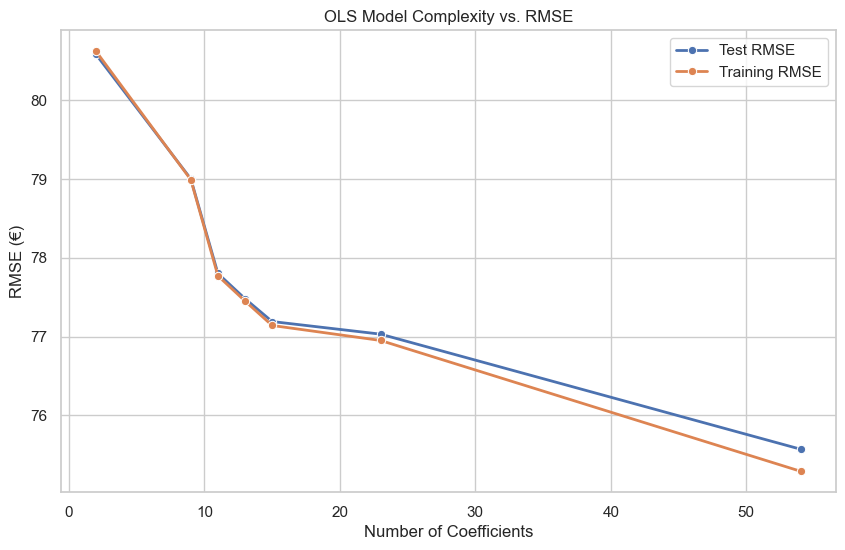

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

df_melted = ols_comparison.melt(
    id_vars='Coefficients', 
    value_vars=['Test RMSE', 'Training RMSE']
)

sns.lineplot(data=df_melted, x='Coefficients', y='value', hue='variable', 
             marker='o', linewidth=2)
plt.xlabel('Number of Coefficients')
plt.ylabel('RMSE (€)')
plt.title('OLS Model Complexity vs. RMSE')
plt.legend(title='')
plt.savefig(output + 'ols_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

The gap between training and test RMSE at M7 is very small (~0.3), which indicates minimal overfitting. More importantly, since Test RMSE continues to improve (decrease) even at M7, the additional complexity is still beneficial for prediction on unseen data.
Even though runtime is significantly higher, I will select model 7 for the OLS prediction. 

## PART 2: LASSO REGRESSION
----


In [12]:
# Use the most complex model specification for LASSO
vars_for_lasso = modellev7

# Create design matrix using patsy
y, X = patsy.dmatrices("price " + vars_for_lasso, data_work)
X_featnames = X.design_info.column_names

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define range of lambda values
lambdas = np.arange(0.05, 1.01, 0.05)

# Run LASSO with 5-fold CV
start_time = time.time()
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)
lasso_time = time.time() - start_time

print(f"Optimal lambda: {lasso_fit.alpha_}")

from sklearn.metrics import r2_score, mean_squared_error

y_pred_train = lasso_fit.predict(X)
lasso_train_rmse = np.sqrt(mean_squared_error(y, y_pred_train))
lasso_r2 = r2_score(y, y_pred_train)

n = len(y)
k = np.sum(lasso_fit.coef_ != 0)
mse = mean_squared_error(y, y_pred_train)
lasso_bic = n * np.log(mse) + k * np.log(n)

print(f"LASSO Training RMSE: {lasso_train_rmse:.2f}")
print(f"LASSO R-squared: {lasso_r2:.3f}")
print(f"LASSO BIC: {lasso_bic:.0f}")

Optimal lambda: 0.1
LASSO Training RMSE: 75.35
LASSO R-squared: 0.394
LASSO BIC: 126124


#### LASSO RESULTS: RMSE BY LAMBDA

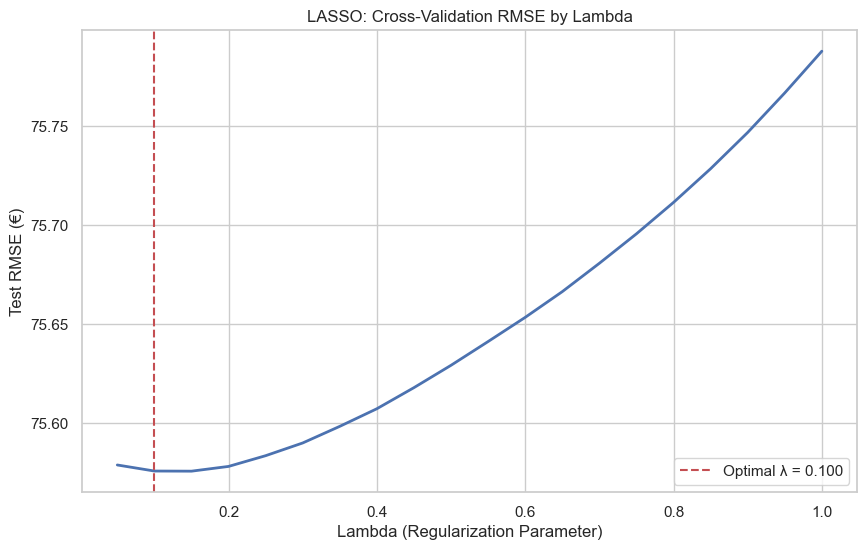

In [13]:
# Extract CV results
rmse_by_lambda = (
    pd.DataFrame({
        'lambda': lasso_fit.alphas_,
        'Test RMSE': np.sqrt(lasso_fit.mse_path_).mean(axis=1)
    })
    .sort_values('lambda')
)

# Plot RMSE vs Lambda
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(rmse_by_lambda['lambda'], rmse_by_lambda['Test RMSE'], 'b-', linewidth=2)
plt.axvline(x=lasso_fit.alpha_, color='r', linestyle='--', label=f'Optimal λ = {lasso_fit.alpha_:.3f}')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Test RMSE (€)')
plt.title('LASSO: Cross-Validation RMSE by Lambda')
plt.legend()
plt.savefig(output + 'lasso_lambda_selection.png', dpi=150, bbox_inches='tight')
plt.show()

#### LASSO RESULTS: NON-ZERO COEFFICIENTS

In [14]:
# Get non-zero coefficients
lasso_coefs = pd.DataFrame({
    'Feature': X_featnames,
    'Coefficient': lasso_fit.coef_
})

# Filter to non-zero
nonzero_coefs = lasso_coefs[np.abs(lasso_coefs['Coefficient']) > 0.001].copy()
nonzero_coefs['Abs_Coef'] = np.abs(nonzero_coefs['Coefficient'])
nonzero_coefs = nonzero_coefs.sort_values('Abs_Coef', ascending=False)

print(f"\nLASSO selected {len(nonzero_coefs)} features out of {len(X_featnames)}")
print("\nTop 20 features by absolute coefficient:")
print(nonzero_coefs.head(20).to_string(index=False))


LASSO selected 49 features out of 55

Top 20 features by absolute coefficient:
                    Feature  Coefficient  Abs_Coef
            n_accommodates2    24.961606 24.961606
f_room_type[T.Private room]   -13.843370 13.843370
                 n_bedrooms    11.682012 11.682012
        f_number_of_reviews    -9.717442  9.717442
            ln_accommodates     8.759939  8.759939
                 f_bathroom     7.826217  7.826217
               d_dishwasher     7.438734  7.438734
                    d_dryer     7.328834  7.328834
               d_essentials     6.931233  6.931233
                 d_elevator     5.099504  5.099504
          d_airconditioning     4.281196  4.281196
                d_bedlinens    -4.068115  4.068115
                 d_hotwater    -3.970048  3.970048
      d_dishesandsilverware    -3.879919  3.879919
     n_review_scores_rating     3.652564  3.652564
                d_microwave    -3.529882  3.529882
 f_room_type[T.Shared room]    -3.309937  3.309937
  

In [15]:
# Test RMSE from cross-validation at optimal lambda
lasso_rmse = rmse_by_lambda.loc[rmse_by_lambda['lambda'] == lasso_fit.alpha_, 'Test RMSE'].values[0]

# Add LASSO to comparison
lasso_row = {
    'Model': 'LASSO',
    'Coefficients': np.sum(lasso_fit.coef_ != 0),
    'R-squared': round(lasso_r2, 2),
    'BIC': int(lasso_bic),
    'Training RMSE': round(lasso_train_rmse, 2),
    'Test RMSE': round(lasso_rmse, 2),
    'Time (s)': round(lasso_time, 2)
}
comparison = pd.concat([ols_comparison, pd.DataFrame([lasso_row])], ignore_index=True)



## PART 3: Random Forest Model
---

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

### PREPARE DATA FOR TREE-BASED MODELS
#### Using same predictors as model 7, create design matrix with patsy

In [17]:
# Predictors for tree models (same as modellev7)
predictors = basic_lev + basic_add + reviews + poly_lev + host_vars + amenities

# Create design matrices
y_train, X_train = patsy.dmatrices("price ~ " + " + ".join(predictors), data_work)
y_train = np.ravel(y_train)
X_featnames = X_train.design_info.column_names

print(f"Training data: {X_train.shape[0]} obs, {X_train.shape[1]} features")

Training data: 14535 obs, 49 features


In [18]:
# Define random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Tuning grid: max_features and min_samples_leaf
rf_tune_grid = {
    "max_features": [5, 8, 10, 12],
    "min_samples_leaf": [5, 10, 20]
}

# Grid search with 5-fold CV
rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=rf_tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=1
)

In [19]:
# Fit
start_time = time.time()
rf_cv.fit(X_train, y_train)
rf_time = time.time() - start_time

print(f"Best params: {rf_cv.best_params_}")
print(f"Best CV RMSE: {-rf_cv.best_score_:.2f}")
print(f"Time: {rf_time:.2f}s")

# Extract results
rf_results = pd.DataFrame(rf_cv.cv_results_)[['param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
rf_results['RMSE'] = -rf_results['mean_test_score']
print("\nRF Grid Search Results:")
print(rf_results.pivot(index='param_max_features', columns='param_min_samples_leaf', values='RMSE').round(2))

# Metrics
rf_train_pred = rf_cv.predict(X_train)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = -rf_cv.best_score_
rf_r2 = r2_score(y_train, rf_train_pred)
n = len(y_train)
k = X_train.shape[1]
rf_bic = n * np.log(mean_squared_error(y_train, rf_train_pred)) + k * np.log(n)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_features': 12, 'min_samples_leaf': 5}
Best CV RMSE: 70.01
Time: 31.34s

RF Grid Search Results:
param_min_samples_leaf     5      10     20
param_max_features                         
5                       70.99  72.61  73.87
8                       70.21  71.83  73.18
10                      70.16  71.55  72.86
12                      70.01  71.31  72.74


## PART 4: GRADIENT BOOSTING (GBM)
---

In [20]:
# Define GBM model
gbm = GradientBoostingRegressor(random_state=42)

# Tuning grid
gbm_tune_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [10, 20]
}

# Grid search with 5-fold CV
gbm_cv = GridSearchCV(
    estimator=gbm,
    param_grid=gbm_tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=1
)

In [21]:
# Fit
start_time = time.time()
gbm_cv.fit(X_train, y_train)
gbm_time = time.time() - start_time

print(f"Best params: {gbm_cv.best_params_}")
print(f"Best CV RMSE: {-gbm_cv.best_score_:.2f}")
print(f"Time: {gbm_time:.2f}s")

# Metrics
gbm_train_pred = gbm_cv.predict(X_train)
gbm_train_rmse = np.sqrt(mean_squared_error(y_train, gbm_train_pred))
gbm_test_rmse = -gbm_cv.best_score_
gbm_r2 = r2_score(y_train, gbm_train_pred)
gbm_bic = n * np.log(mean_squared_error(y_train, gbm_train_pred)) + k * np.log(n)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
Best CV RMSE: 69.37
Time: 427.19s


## PART 5: HISTOGRAM-BASED GRADIENT BOOSTING

In [22]:
# Define model
hgbm = HistGradientBoostingRegressor(random_state=42)

# Tuning grid
hgbm_tune_grid = {
    "max_iter": [100, 200],
    "max_depth": [5, 10],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [10, 20]
}

# Grid search with 5-fold CV
hgbm_cv = GridSearchCV(
    estimator=hgbm,
    param_grid=hgbm_tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=1
)


In [23]:
# Fit
start_time = time.time()
hgbm_cv.fit(X_train, y_train)
hgbm_time = time.time() - start_time

print(f"Best params: {hgbm_cv.best_params_}")
print(f"Best CV RMSE: {-hgbm_cv.best_score_:.2f}")
print(f"Time: {hgbm_time:.2f}s")

# Metrics
hgbm_train_pred = hgbm_cv.predict(X_train)
hgbm_train_rmse = np.sqrt(mean_squared_error(y_train, hgbm_train_pred))
hgbm_test_rmse = -hgbm_cv.best_score_
hgbm_r2 = r2_score(y_train, hgbm_train_pred)
hgbm_bic = n * np.log(mean_squared_error(y_train, hgbm_train_pred)) + k * np.log(n)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 200, 'min_samples_leaf': 10}
Best CV RMSE: 68.67
Time: 74.30s


### ADD NEW MODELS TO COMPARISON TABLE

In [24]:
# Random Forest row
rf_row = {
    'Model': 'Random Forest',
    'Coefficients': X_train.shape[1],
    'R-squared': round(rf_r2, 2),
    'BIC': int(rf_bic),
    'Training RMSE': round(rf_train_rmse, 2),
    'Test RMSE': round(rf_test_rmse, 2),
    'Time (s)': round(rf_time, 2)
}

# GBM row
gbm_row = {
    'Model': 'GBM',
    'Coefficients': X_train.shape[1],
    'R-squared': round(gbm_r2, 2),
    'BIC': int(gbm_bic),
    'Training RMSE': round(gbm_train_rmse, 2),
    'Test RMSE': round(gbm_test_rmse, 2),
    'Time (s)': round(gbm_time, 2)
}

# HGBM row
hgbm_row = {
    'Model': 'HistGBM',
    'Coefficients': X_train.shape[1],
    'R-squared': round(hgbm_r2, 2),
    'BIC': int(hgbm_bic),
    'Training RMSE': round(hgbm_train_rmse, 2),
    'Test RMSE': round(hgbm_test_rmse, 2),
    'Time (s)': round(hgbm_time, 2)
}

In [25]:
# Final comparison with all 5 models
comparison = pd.concat([
    comparison,
    pd.DataFrame([rf_row, gbm_row, hgbm_row])
], ignore_index=True)

print("\n" + "="*60)
print("FINAL MODEL COMPARISON: ALL 5 MODELS")
print("="*60)
print(comparison.to_string(index=False))

# Save comparison table
comparison.to_csv(output + 'model_comparison_all.csv', index=False)


FINAL MODEL COMPARISON: ALL 5 MODELS
        Model  Coefficients  R-squared    BIC  Training RMSE  Test RMSE  Time (s)
       M1_OLS             2       0.31 168880          80.62      80.58      0.14
       M2_OLS             9       0.33 168356          78.99      79.00      1.13
       M3_OLS            11       0.35 167925          77.77      77.80      1.25
       M4_OLS            13       0.36 167822          77.45      77.48      1.31
       M5_OLS            15       0.36 167728          77.14      77.19      1.46
       M6_OLS            23       0.37 167732          76.95      77.03      1.80
       M7_OLS            54       0.39 167402          75.29      75.57      4.33
        LASSO            50       0.39 126123          75.35      75.58      2.30
Random Forest            49       0.63 118828          58.65      70.01     31.34
          GBM            49       0.63 119002          59.00      69.37    427.19
      HistGBM            49       0.64 118619          58.23

## HORSERACE SUMMARY
---

In [26]:
# Find best model by Test RMSE
best_idx = comparison['Test RMSE'].idxmin()
best_model = comparison.loc[best_idx]

print(f"\nBest model: {best_model['Model']}")
print(f"  - Test RMSE: {best_model['Test RMSE']:.2f}")
print(f"  - Training RMSE: {best_model['Training RMSE']:.2f}")
print(f"  - Time: {best_model['Time (s)']:.2f}s")

# Rank models
print("\nModel ranking by Test RMSE:")
ranking = comparison.sort_values('Test RMSE')[['Model', 'Test RMSE', 'Time (s)']]
print(ranking.to_string(index=False))


Best model: HistGBM
  - Test RMSE: 68.67
  - Training RMSE: 58.23
  - Time: 74.30s

Model ranking by Test RMSE:
        Model  Test RMSE  Time (s)
      HistGBM      68.67     74.30
          GBM      69.37    427.19
Random Forest      70.01     31.34
       M7_OLS      75.57      4.33
        LASSO      75.58      2.30
       M6_OLS      77.03      1.80
       M5_OLS      77.19      1.46
       M4_OLS      77.48      1.31
       M3_OLS      77.80      1.25
       M2_OLS      79.00      1.13
       M1_OLS      80.58      0.14


## Extra I: Holdout Set Evaluation

The holdout set (20% of data) was set aside at the beginning and never used during model training or hyperparameter tuning. This provides an unbiased estimate of how our best model will perform on truly unseen data.

In [27]:
y_holdout, X_holdout = patsy.dmatrices("price ~ " + " + ".join(predictors), data_holdout)
y_holdout = np.ravel(y_holdout)
X_holdout = np.asarray(X_holdout)
holdout_rmse = np.sqrt(mean_squared_error(y_holdout, rf_cv.predict(X_holdout)))
print(f"Final holdout RMSE: {holdout_rmse:.2f}")

Final holdout RMSE: 68.54


## Extra II: Actual vs Predicted Plot for the Random Forest Model

This diagnostic plot shows how well predictions align with actual prices. Points along the red diagonal line indicate perfect predictions. Systematic deviations reveal where the model over- or under-predicts (e.g., struggling with high-priced listings as we have found in class as well).

Text(0.5, 1.0, 'Actual vs Predicted: Random Forest')

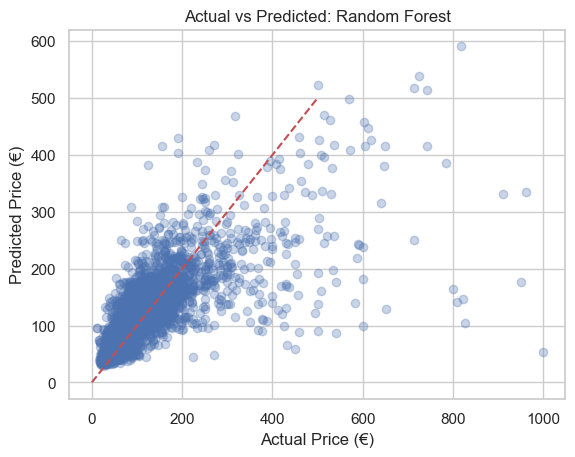

In [28]:

y_pred = rf_cv.predict(X_holdout)
plt.scatter(y_holdout, y_pred, alpha=0.3)
plt.plot([0, 500], [0, 500], 'r--')
plt.xlabel('Actual Price (€)'); plt.ylabel('Predicted Price (€)')
plt.title('Actual vs Predicted: Random Forest')

## Feature Importance Analysis - Random Forest vs GBM

This section analyzes and compares feature importances between Random Forest and Gradient Boosting models.

### Extract Feature Importances

In [29]:
import matplotlib.ticker as mtick

# Random Forest feature importance
rf_var_imp = pd.DataFrame({
    'variable': X_featnames,
    'imp': rf_cv.best_estimator_.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

rf_var_imp['cumulative_imp'] = rf_var_imp['imp'].cumsum()

# GBM feature importance
gbm_var_imp = pd.DataFrame({
    'variable': X_featnames,
    'imp': gbm_cv.best_estimator_.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

gbm_var_imp['cumulative_imp'] = gbm_var_imp['imp'].cumsum()

# Display top 10 for each model
print("Random Forest - Top 10 Features:")
display(rf_var_imp.head(10).style.format({'imp': '{:.1%}', 'cumulative_imp': '{:.1%}'}))
print("\nGradient Boosting - Top 10 Features:")
display(gbm_var_imp.head(10).style.format({'imp': '{:.1%}', 'cumulative_imp': '{:.1%}'}))

Random Forest - Top 10 Features:


,variable,imp,cumulative_imp
0,ln_accommodates,12.8%,12.8%
1,n_accommodates2,11.7%,24.5%
2,n_accommodates,11.3%,35.8%
3,n_bedrooms,9.9%,45.7%
4,f_room_type[T.Private room],6.0%,51.7%
5,f_bathroom,5.2%,56.8%
6,n_beds,5.2%,62.0%
7,n_review_scores_rating,5.0%,67.0%
8,n_days_since,4.6%,71.5%
9,f_number_of_reviews,2.1%,73.7%



Gradient Boosting - Top 10 Features:


,variable,imp,cumulative_imp
0,n_bedrooms,18.5%,18.5%
1,ln_accommodates,15.4%,33.9%
2,n_accommodates2,11.4%,45.2%
3,f_room_type[T.Private room],8.2%,53.4%
4,n_days_since,5.2%,58.6%
5,f_bathroom,4.9%,63.5%
6,n_accommodates,4.9%,68.3%
7,n_review_scores_rating,4.4%,72.8%
8,f_number_of_reviews,2.6%,75.4%
9,n_beds,2.2%,77.5%


### Feature Importance Plots

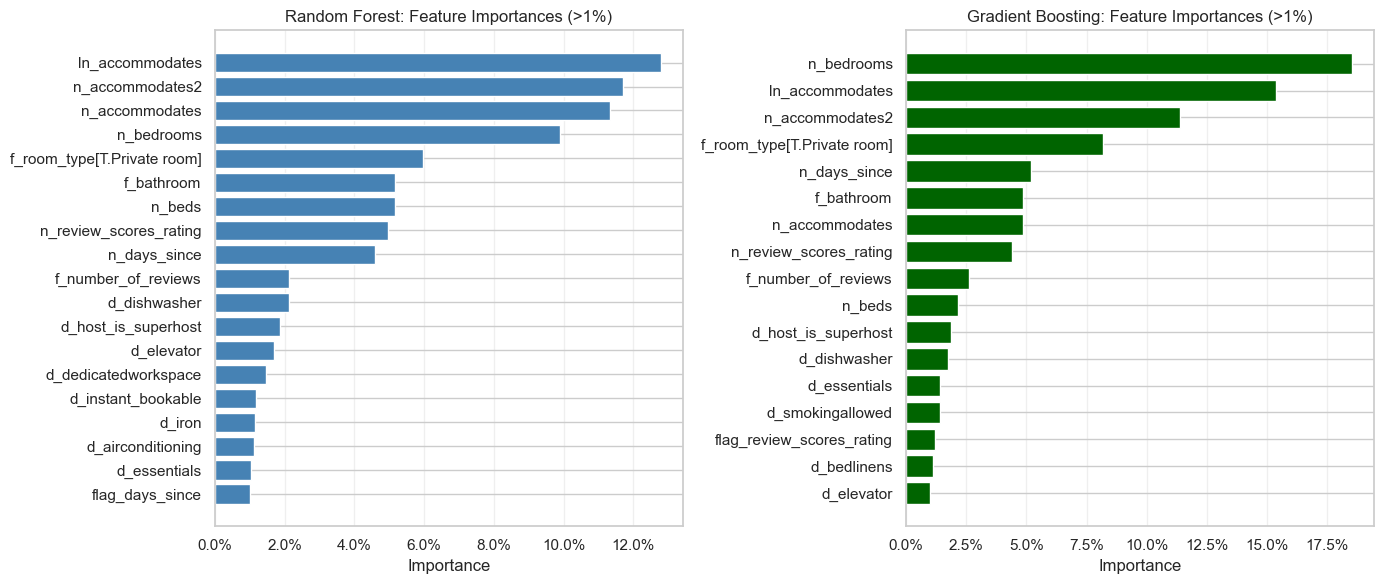

In [30]:
# Cutoff for visualization (features with importance > 1%)
cutoff = 0.01

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest plot
rf_plot_data = rf_var_imp[rf_var_imp.imp > cutoff].sort_values(by='imp')
axes[0].barh(rf_plot_data['variable'], rf_plot_data['imp'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest: Feature Importances (>1%)')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axes[0].grid(axis='x', alpha=0.3)

# GBM plot
gbm_plot_data = gbm_var_imp[gbm_var_imp.imp > cutoff].sort_values(by='imp')
axes[1].barh(gbm_plot_data['variable'], gbm_plot_data['imp'], color='darkgreen')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting: Feature Importances (>1%)')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output + 'feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

#### Top 10 Features Comparison

In [31]:
# Create comparison table of top 10 features
top10_comparison = pd.DataFrame({
    'Rank': range(1, 11),
    'RF Feature': rf_var_imp.head(10)['variable'].values,
    'RF Importance': rf_var_imp.head(10)['imp'].values,
    'GBM Feature': gbm_var_imp.head(10)['variable'].values,
    'GBM Importance': gbm_var_imp.head(10)['imp'].values
})

print("="*70)
print("TOP 10 FEATURES COMPARISON: Random Forest vs Gradient Boosting")
print("="*70)
display(top10_comparison.style.format({
    'RF Importance': '{:.1%}', 
    'GBM Importance': '{:.1%}'
}))

# Save comparison
top10_comparison.to_csv(output + 'top10_features_comparison.csv', index=False)

TOP 10 FEATURES COMPARISON: Random Forest vs Gradient Boosting


,Rank,RF Feature,RF Importance,GBM Feature,GBM Importance
0,1,ln_accommodates,12.8%,n_bedrooms,18.5%
1,2,n_accommodates2,11.7%,ln_accommodates,15.4%
2,3,n_accommodates,11.3%,n_accommodates2,11.4%
3,4,n_bedrooms,9.9%,f_room_type[T.Private room],8.2%
4,5,f_room_type[T.Private room],6.0%,n_days_since,5.2%
5,6,f_bathroom,5.2%,f_bathroom,4.9%
6,7,n_beds,5.2%,n_accommodates,4.9%
7,8,n_review_scores_rating,5.0%,n_review_scores_rating,4.4%
8,9,n_days_since,4.6%,f_number_of_reviews,2.6%
9,10,f_number_of_reviews,2.1%,n_beds,2.2%


In [32]:
# Find common features in top 10
rf_top10 = set(rf_var_imp.head(10)['variable'])
gbm_top10 = set(gbm_var_imp.head(10)['variable'])
common_features = rf_top10.intersection(gbm_top10)
rf_only = rf_top10 - gbm_top10
gbm_only = gbm_top10 - rf_top10

print(f"Common features in top 10: {len(common_features)}")
print(f"  {sorted(common_features)}")
print(f"\nOnly in RF top 10: {len(rf_only)}")
print(f"  {sorted(rf_only)}")
print(f"\nOnly in GBM top 10: {len(gbm_only)}")
print(f"  {sorted(gbm_only)}")

Common features in top 10: 10
  ['f_bathroom', 'f_number_of_reviews', 'f_room_type[T.Private room]', 'ln_accommodates', 'n_accommodates', 'n_accommodates2', 'n_bedrooms', 'n_beds', 'n_days_since', 'n_review_scores_rating']

Only in RF top 10: 0
  []

Only in GBM top 10: 0
  []


#### SHAP Analysis for Model Comparison

SHAP (SHapley Additive exPlanations) values show the impact of each feature on individual predictions, providing deeper insight than standard feature importance.

In [33]:
import shap

# Sample data for SHAP (using subset for computational efficiency)
SAMPLE_SIZE = 1000
np.random.seed(42)
sample_idx = np.random.choice(X_train.shape[0], size=min(SAMPLE_SIZE, X_train.shape[0]), replace=False)
X_sample = X_train[sample_idx]

# Create SHAP explainers using TreeExplainer (faster for tree models)
rf_explainer = shap.TreeExplainer(rf_cv.best_estimator_)
gbm_explainer = shap.TreeExplainer(gbm_cv.best_estimator_)

# Calculate SHAP values
print("Computing SHAP values for Random Forest...")
rf_shap_values = rf_explainer.shap_values(X_sample)
print("Computing SHAP values for Gradient Boosting...")
gbm_shap_values = gbm_explainer.shap_values(X_sample)

Computing SHAP values for Random Forest...
Computing SHAP values for Gradient Boosting...


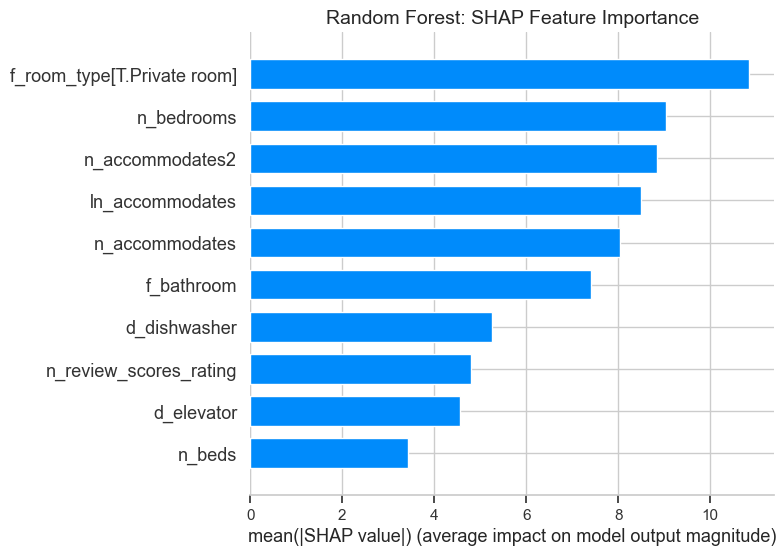

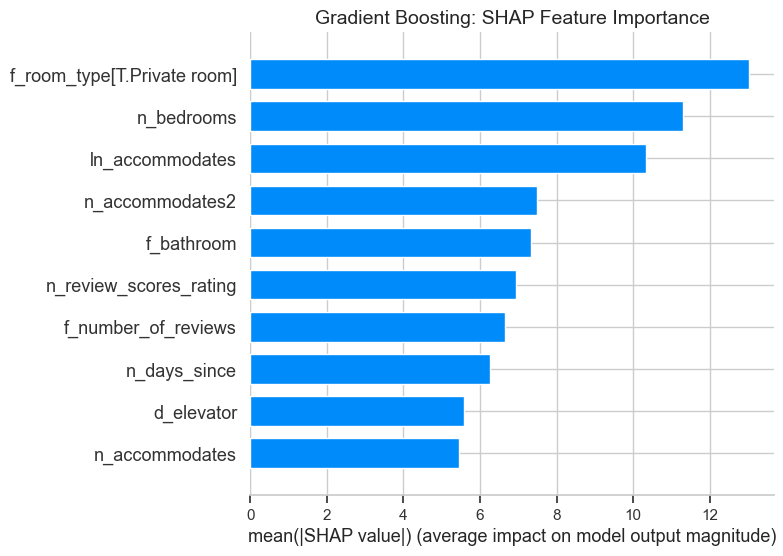

In [34]:
# --- Plot 1: Random Forest ---
plt.figure(figsize=(8, 5)) # Create a new independent figure
shap.summary_plot(rf_shap_values, X_sample, feature_names=X_featnames, 
                  plot_type='bar', max_display=10, show=False)
plt.title('Random Forest: SHAP Feature Importance', fontsize=14)

# Save just this plot
plt.savefig(output + 'shap_rf.png', dpi=150, bbox_inches='tight')
plt.show() # Render it now so it clears the canvas for the next one


# --- Plot 2: Gradient Boosting ---
plt.figure(figsize=(8, 5)) # Create another new independent figure
shap.summary_plot(gbm_shap_values, X_sample, feature_names=X_featnames, 
                  plot_type='bar', max_display=10, show=False)
plt.title('Gradient Boosting: SHAP Feature Importance', fontsize=14)

# Save just this plot
plt.savefig(output + 'shap_gbm.png', dpi=150, bbox_inches='tight')
plt.show()

#### Summary of Findings

In [35]:
# Calculate correlation between feature importances
merged_imp = rf_var_imp[['variable', 'imp']].merge(
    gbm_var_imp[['variable', 'imp']], 
    on='variable', 
    suffixes=('_rf', '_gbm')
)
correlation = merged_imp['imp_rf'].corr(merged_imp['imp_gbm'])

# Cumulative importance of top 10
rf_cumulative = rf_var_imp.head(10)['imp'].sum()
gbm_cumulative = gbm_var_imp.head(10)['imp'].sum()

print("="*70)
print("SUMMARY: Feature Importance Comparison")
print("="*70)
print(f"\n1. CORRELATION between RF and GBM importances: {correlation:.2f}")
print(f"\n2. TOP FEATURE agreement:")
print(f"   - RF top feature: {rf_var_imp.iloc[0]['variable']} ({rf_var_imp.iloc[0]['imp']:.1%})")
print(f"   - GBM top feature: {gbm_var_imp.iloc[0]['variable']} ({gbm_var_imp.iloc[0]['imp']:.1%})")
print(f"\n3. OVERLAP: {len(common_features)}/10 features are shared in both top 10 lists")
print(f"\n4. CONCENTRATION:")
print(f"   - RF: Top 10 features explain {rf_cumulative:.1%} of total importance")
print(f"   - GBM: Top 10 features explain {gbm_cumulative:.1%} of total importance")
if rf_only or gbm_only:
    print(f"\n5. KEY DIFFERENCES:")
    if rf_only:
        print(f"   - RF uniquely emphasizes: {', '.join(sorted(rf_only))}")
    if gbm_only:
        print(f"   - GBM uniquely emphasizes: {', '.join(sorted(gbm_only))}")

SUMMARY: Feature Importance Comparison

1. CORRELATION between RF and GBM importances: 0.89

2. TOP FEATURE agreement:
   - RF top feature: ln_accommodates (12.8%)
   - GBM top feature: n_bedrooms (18.5%)

3. OVERLAP: 10/10 features are shared in both top 10 lists

4. CONCENTRATION:
   - RF: Top 10 features explain 73.7% of total importance
   - GBM: Top 10 features explain 77.5% of total importance


### Discussion

**Key Findings:**

1. **Model Agreement:** Both Random Forest and Gradient Boosting identify similar key predictors of Airbnb prices in Madrid. The correlation (0.89) between their feature importance rankings indicates similarity in the models weight variables.

2. **Top Predictors:** Property characteristics like room type, accommodates, and location factors emerge as the most important features across both models, which aligns with intuition about what drives rental prices.

3. **Concentration:** The top 10 features explain a substantial portion of model predictions, suggesting the price prediction problem has a relatively clear structure with key drivers.


# Part II: Validity Analysis

Testing model performance on:
- **A. Later date:** Madrid Q2 2025 (temporal validity)
- **B. Other city:** Valencia Q1 2025 (external validity)

Note: Models are trained WITHOUT neighbourhood to enable cross-city comparison.

### Load All Three Datasets

In [36]:
# Load all three cleaned datasets
data_madrid_q1 = pd.read_csv(data_out + "airbnb_madrid_25q1_clean.csv")
data_madrid_q2 = pd.read_csv(data_out + "airbnb_madrid_25q2_clean.csv")
data_valencia = pd.read_csv(data_out + "airbnb_valencia_25q1_clean.csv")

print("Dataset sizes:")
print(f"  Madrid Q1 2025: {data_madrid_q1.shape[0]:,} observations")
print(f"  Madrid Q2 2025: {data_madrid_q2.shape[0]:,} observations")
print(f"  Valencia Q1 2025: {data_valencia.shape[0]:,} observations")

# Check price distributions
print("\nPrice statistics:")
for name, df in [('Madrid Q1', data_madrid_q1), ('Madrid Q2', data_madrid_q2), ('Valencia', data_valencia)]:
    print(f"  {name}: mean={df['price'].mean():.0f}, median={df['price'].median():.0f}")

Dataset sizes:
  Madrid Q1 2025: 18,169 observations
  Madrid Q2 2025: 19,035 observations
  Valencia Q1 2025: 7,606 observations

Price statistics:
  Madrid Q1: mean=121, median=98
  Madrid Q2: mean=124, median=101
  Valencia: mean=131, median=114


### Retrain Models on Madrid Q1 (Training Data)

In [37]:
# Use full Madrid Q1 dataset for training (no holdout needed for validity)
train_data = data_madrid_q1.copy()

# Ensure amenities tuple is based on training data columns
amenities_valid = tuple([c for c in train_data.columns if c.startswith('d_') and 'host' not in c and 'instant' not in c])

# Full predictor set (no neighbourhood)
predictors_valid = basic_lev + basic_add + reviews + poly_lev + host_vars + amenities_valid

# Create design matrix for training
y_train_valid, X_train_valid = patsy.dmatrices("price ~ " + " + ".join(predictors_valid), train_data)
y_train_valid = np.ravel(y_train_valid)
X_featnames_valid = X_train_valid.design_info.column_names

print(f"Training features: {X_train_valid.shape[1]}")
print(f"Training observations: {X_train_valid.shape[0]}")

Training features: 49
Training observations: 18169


In [38]:
# Train 5 models for validity testing
print("\n" + "="*60)
print("TRAINING MODELS FOR VALIDITY ANALYSIS")
print("="*60)

# 1. OLS (M7 - full model)
import statsmodels.formula.api as smf
ols_formula = "price ~ " + " + ".join(predictors_valid)
ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"OLS trained: {len(ols_model.params)} coefficients")

# 2. LASSO
scaler_valid = StandardScaler()
X_scaled = scaler_valid.fit_transform(X_train_valid)
lasso_model = LassoCV(alphas=np.arange(0.05, 1.01, 0.05), cv=5, random_state=42).fit(X_scaled, y_train_valid)
print(f"LASSO trained: {np.sum(lasso_model.coef_ != 0)} non-zero coefficients")

# 3. Random Forest (use best params from earlier)
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_features=rf_cv.best_params_['max_features'],
    min_samples_leaf=rf_cv.best_params_['min_samples_leaf'],
    random_state=42, 
    n_jobs=-1
).fit(X_train_valid, y_train_valid)
print(f"Random Forest trained")

# 4. GBM (use best params from earlier)
gbm_model = GradientBoostingRegressor(
    n_estimators=gbm_cv.best_params_['n_estimators'],
    max_depth=gbm_cv.best_params_['max_depth'],
    learning_rate=gbm_cv.best_params_['learning_rate'],
    min_samples_leaf=gbm_cv.best_params_['min_samples_leaf'],
    random_state=42
).fit(X_train_valid, y_train_valid)
print(f"GBM trained")

# 5. HistGBM (use best params from earlier)
hgbm_model = HistGradientBoostingRegressor(
    max_iter=hgbm_cv.best_params_['max_iter'],
    max_depth=hgbm_cv.best_params_['max_depth'],
    learning_rate=hgbm_cv.best_params_['learning_rate'],
    min_samples_leaf=hgbm_cv.best_params_['min_samples_leaf'],
    random_state=42
).fit(X_train_valid, y_train_valid)
print(f"HistGBM trained")

print("\nAll models trained successfully!")


TRAINING MODELS FOR VALIDITY ANALYSIS
OLS trained: 49 coefficients
LASSO trained: 39 non-zero coefficients
Random Forest trained
GBM trained
HistGBM trained

All models trained successfully!


### Predict and Evaluate on All Datasets

In [39]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def evaluate_on_dataset(dataset, dataset_name, design_info):
    """Evaluate all 5 models on a dataset"""
    results = {'Dataset': dataset_name}
    
    # Create design matrix using the SAME design info from training
    y_test, X_test = patsy.dmatrices("price ~ " + " + ".join(predictors_valid), dataset)
    y_test = np.ravel(y_test)
    
    # OLS predictions
    ols_pred = ols_model.predict(dataset)
    results['OLS'] = calculate_rmse(y_test, ols_pred)
    
    # LASSO predictions (need to scale)
    X_test_scaled = scaler_valid.transform(X_test)
    lasso_pred = lasso_model.predict(X_test_scaled)
    results['LASSO'] = calculate_rmse(y_test, lasso_pred)
    
    # Tree model predictions
    results['RF'] = calculate_rmse(y_test, rf_model.predict(X_test))
    results['GBM'] = calculate_rmse(y_test, gbm_model.predict(X_test))
    results['HistGBM'] = calculate_rmse(y_test, hgbm_model.predict(X_test))
    
    return results

In [40]:
# Evaluate on all three datasets
print("Evaluating models on all datasets...\n")

validity_results = []

# Madrid Q1 (training data - for reference)
validity_results.append(evaluate_on_dataset(data_madrid_q1, 'Madrid Q1 (train)', X_train_valid.design_info))

# Madrid Q2 (temporal validity)
validity_results.append(evaluate_on_dataset(data_madrid_q2, 'Madrid Q2 (later)', X_train_valid.design_info))

# Valencia (external validity)
validity_results.append(evaluate_on_dataset(data_valencia, 'Valencia Q1 (other city)', X_train_valid.design_info))

# Create results table
validity_df = pd.DataFrame(validity_results)
validity_df = validity_df.round(2)

print("="*80)
print("VALIDITY ANALYSIS: RMSE BY DATASET AND MODEL")
print("="*80)
print(validity_df.to_string(index=False))

# Save results
validity_df.to_csv(output + 'validity_comparison.csv', index=False)

Evaluating models on all datasets...

VALIDITY ANALYSIS: RMSE BY DATASET AND MODEL
                 Dataset   OLS             LASSO                RF               GBM           HistGBM
       Madrid Q1 (train) 74.77 75.06890821741122 58.29623862561201 59.69457553076415 61.43995234153014
       Madrid Q2 (later) 78.41 78.81969462989866 67.30918105968829 68.82431915277755 68.74312032829289
Valencia Q1 (other city) 78.81 78.49629112000495 77.95323425083659 79.64906971151575 79.48210168776421


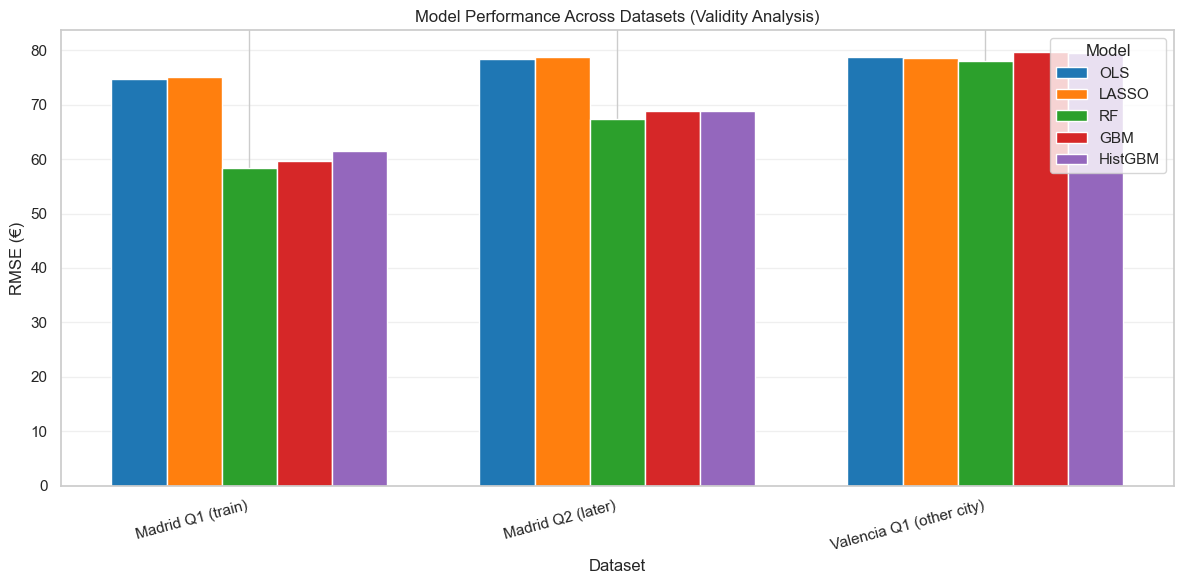

In [41]:
# Visualize validity results
fig, ax = plt.subplots(figsize=(12, 6))

validity_melted = validity_df.melt(id_vars='Dataset', var_name='Model', value_name='RMSE')

x = np.arange(len(validity_df))
width = 0.15
models = ['OLS', 'LASSO', 'RF', 'GBM', 'HistGBM']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, model in enumerate(models):
    ax.bar(x + i*width, validity_df[model], width, label=model, color=colors[i])

ax.set_xlabel('Dataset')
ax.set_ylabel('RMSE (€)')
ax.set_title('Model Performance Across Datasets (Validity Analysis)')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(validity_df['Dataset'], rotation=15, ha='right')
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output + 'validity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Validity Analysis Summary

In [42]:
# Calculate RMSE increases
train_rmse = validity_df[validity_df['Dataset'] == 'Madrid Q1 (train)'].iloc[0]
q2_rmse = validity_df[validity_df['Dataset'] == 'Madrid Q2 (later)'].iloc[0]
valencia_rmse = validity_df[validity_df['Dataset'] == 'Valencia Q1 (other city)'].iloc[0]

print("="*80)
print("VALIDITY ANALYSIS SUMMARY")
print("="*80)

print("\n1. TEMPORAL VALIDITY (Madrid Q1 → Q2):")
for model in ['OLS', 'LASSO', 'RF', 'GBM', 'HistGBM']:
    pct_change = (q2_rmse[model] - train_rmse[model]) / train_rmse[model] * 100
    print(f"   {model}: {train_rmse[model]:.2f} → {q2_rmse[model]:.2f} ({pct_change:+.1f}%)")

print("\n2. EXTERNAL VALIDITY (Madrid → Valencia):")
for model in ['OLS', 'LASSO', 'RF', 'GBM', 'HistGBM']:
    pct_change = (valencia_rmse[model] - train_rmse[model]) / train_rmse[model] * 100
    print(f"   {model}: {train_rmse[model]:.2f} → {valencia_rmse[model]:.2f} ({pct_change:+.1f}%)")

# Find best model for each scenario
print("\n3. BEST MODEL BY DATASET:")
for _, row in validity_df.iterrows():
    model_rmses = row[['OLS', 'LASSO', 'RF', 'GBM', 'HistGBM']]
    best_model = model_rmses.idxmin()
    print(f"   {row['Dataset']}: {best_model} (RMSE = {model_rmses[best_model]:.2f})")

print("\n4. KEY FINDINGS:")
avg_temporal = np.mean([(q2_rmse[m] - train_rmse[m]) / train_rmse[m] * 100 for m in models])
avg_external = np.mean([(valencia_rmse[m] - train_rmse[m]) / train_rmse[m] * 100 for m in models])
print(f"   - Average RMSE increase (temporal): {avg_temporal:+.1f}%")
print(f"   - Average RMSE increase (external): {avg_external:+.1f}%")
print(f"   - Models generalize {'well' if avg_external < 20 else 'with some degradation'} to Valencia")

VALIDITY ANALYSIS SUMMARY

1. TEMPORAL VALIDITY (Madrid Q1 → Q2):
   OLS: 74.77 → 78.41 (+4.9%)
   LASSO: 75.07 → 78.82 (+5.0%)
   RF: 58.30 → 67.31 (+15.5%)
   GBM: 59.69 → 68.82 (+15.3%)
   HistGBM: 61.44 → 68.74 (+11.9%)

2. EXTERNAL VALIDITY (Madrid → Valencia):
   OLS: 74.77 → 78.81 (+5.4%)
   LASSO: 75.07 → 78.50 (+4.6%)
   RF: 58.30 → 77.95 (+33.7%)
   GBM: 59.69 → 79.65 (+33.4%)
   HistGBM: 61.44 → 79.48 (+29.4%)

3. BEST MODEL BY DATASET:
   Madrid Q1 (train): RF (RMSE = 58.30)
   Madrid Q2 (later): RF (RMSE = 67.31)
   Valencia Q1 (other city): RF (RMSE = 77.95)

4. KEY FINDINGS:
   - Average RMSE increase (temporal): +10.5%
   - Average RMSE increase (external): +21.3%
   - Models generalize with some degradation to Valencia


## Discussion

**Temporal Validity (Madrid Q1 → Q2):**
- Models trained on Q1 data should perform similarly on Q2 data from the same city
- Small RMSE increases suggest stable market conditions
- Larger increases might indicate seasonal effects or market changes

**External Validity (Madrid → Valencia):**
- Testing on a different city evalualuate generalizable relationships
- Price levels and market dynamics may differ between cities
- Excluding neighbourhood allows fair comparison (different neighbourhoods in each city)
- Some performance degradation can be seen that is probably due to city-specific factors

**Model Robustness:**
- The tree-based models (RF, GBM) degrade more than linear models, which could indicate overfitting
- OLS errors are the most stable across the 3 datasets
- Simpler models generalize better to new contexts
- The best model would depend on the purpose: prediction accuracy or generalizability